In [1]:
import os
import gc
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta

import tensorflow as tf

parent_dir = os.path.abspath('..')
sys.path.insert(0, parent_dir)
from utils.helper import fn_plot_tf_hist

In [2]:
PATIENCE = 20
LR_FACTOR = .2
LR_PATIENCE = 5


In [3]:
inpDir = os.path.join('..', 'input')
outDir = '../output'
modelDir = os.path.join('..', 'model')


EPOCHS = 30
ALPHA = .001
TEST_SIZE = .2  


BATCH_SIZE = 32 # default batch size fot tf
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.RandomState(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE) ######

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)

## define data


In [5]:
fileName = 'weatherHistory.csv'

data_df = pd.read_csv(os.path.join(inpDir, fileName))
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


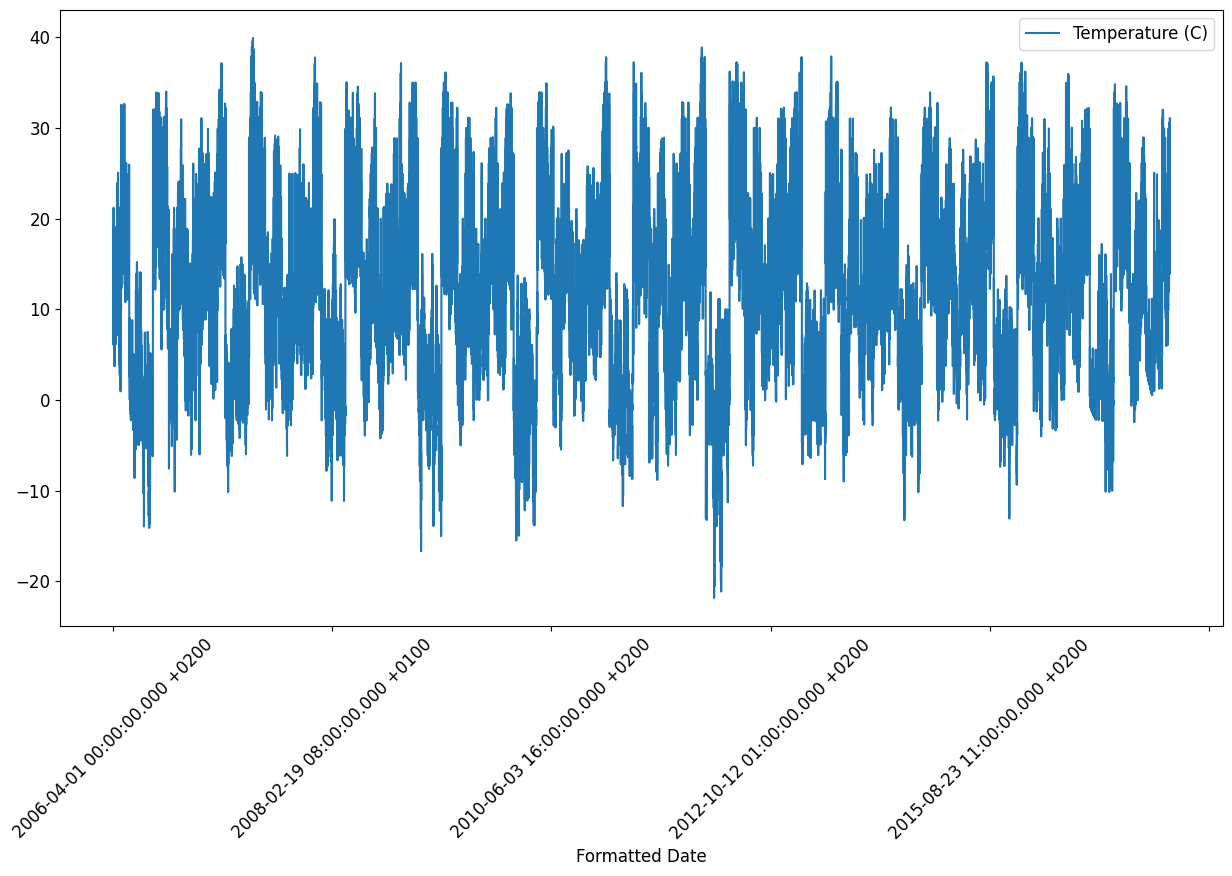

In [6]:
fig, ax = plt.subplots()
data_df.plot(x = 'Formatted Date', y = 'Temperature (C)', ax = ax)
plt.xticks(rotation = 45);

In [7]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc = True)

In [8]:
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,datetime
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00


In [9]:
num_cols = set(data_df.columns) - {'Formatted Date', 'Summary', 'Precip Type', 'Apparent Temperature (C)', 'Loud Cover', 'Daily Summary', 'datetime'}
num_cols = list(num_cols)

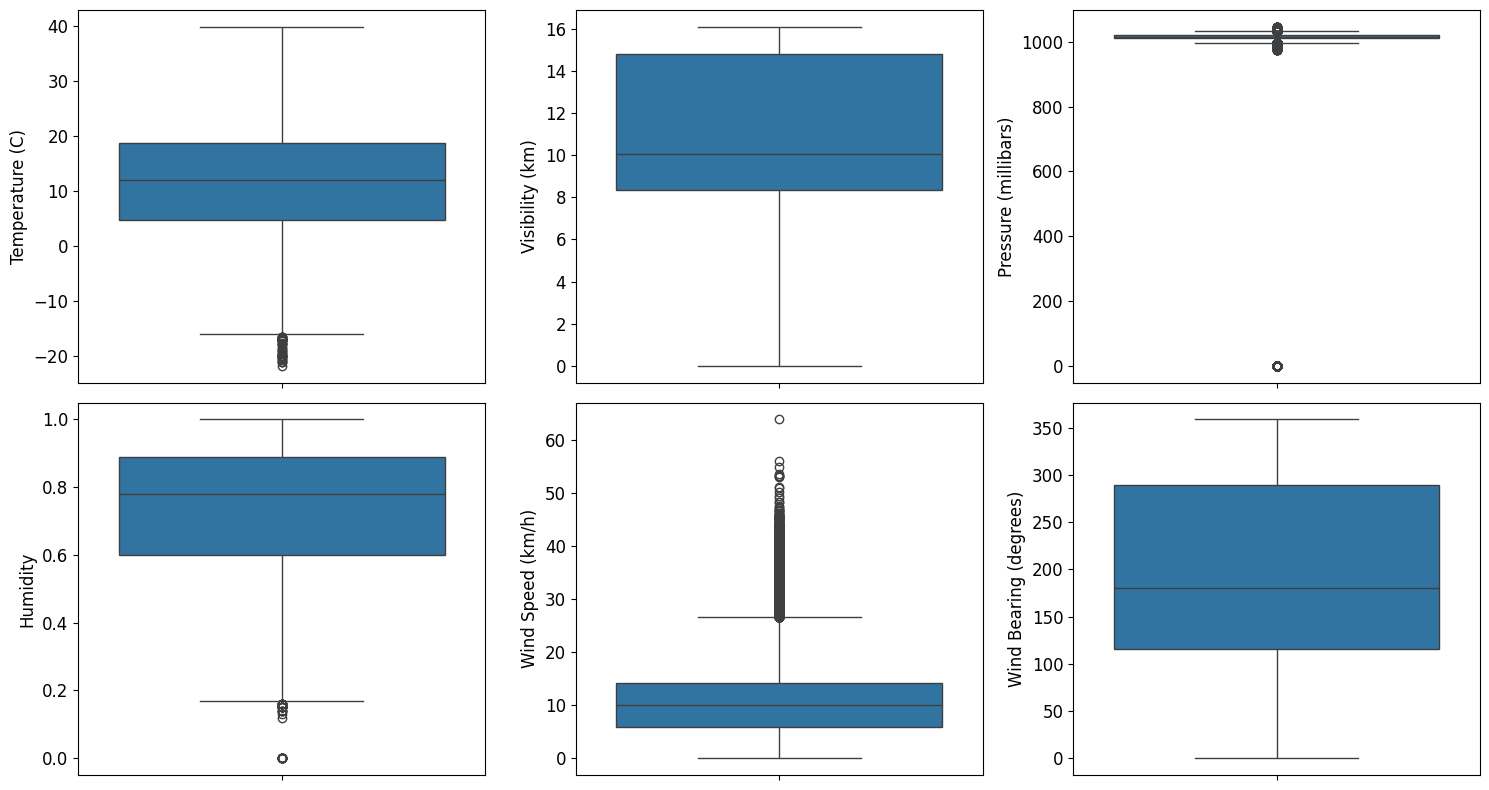

In [77]:
import seaborn as sns
nbim = 100
fig, axes = plt.subplots(2, 3, figsize = (15, 8))

axes = axes.ravel()

for count, col in enumerate(num_cols):
    ax = axes[count]
    # sns.histplot(data= data_df, x = col, ax = ax, bins = nbim)
    sns.boxplot(data = data_df, y= col, ax=ax )
    plt.tight_layout()



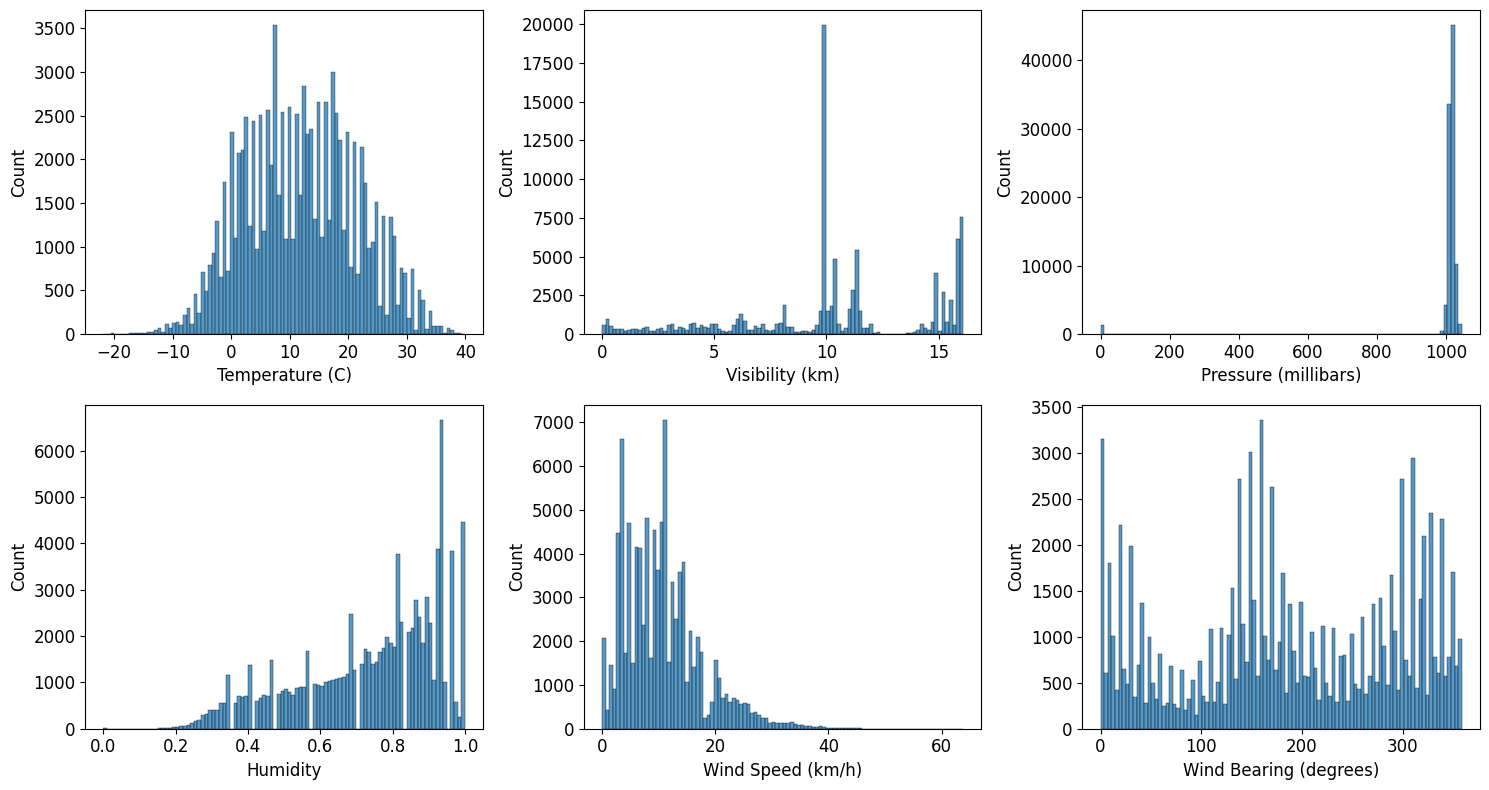

In [81]:
nbim = 100
fig, axes = plt.subplots(2, 3, figsize = (15, 8))

axes = axes.ravel()
for count, col in enumerate(num_cols):
    ax = axes[count]
    sns.histplot(data= data_df, x = col, ax = ax, bins = nbim)
    # sns.boxplot(data = data_df, y= col, ax=ax )
    plt.tight_layout()

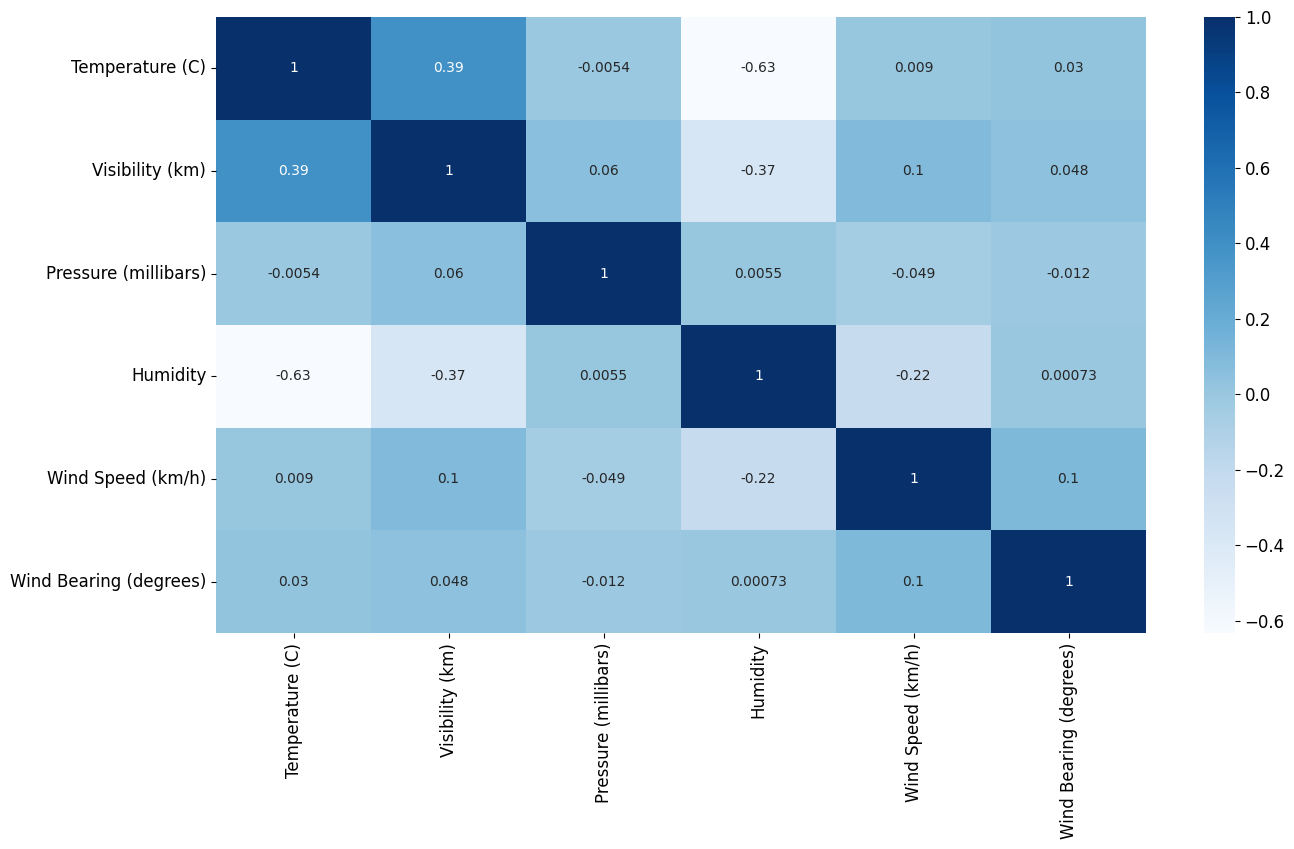

In [11]:
sns.heatmap(data_df[num_cols].corr(), annot = True, cmap = 'Blues');

In [12]:
temp_df= data_df[['datetime','Temperature (C)']]
temp_df = temp_df.sort_values('datetime', axis =0, ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df= temp_df.rename({'Temperature (C)': 'temp'}, axis=1)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


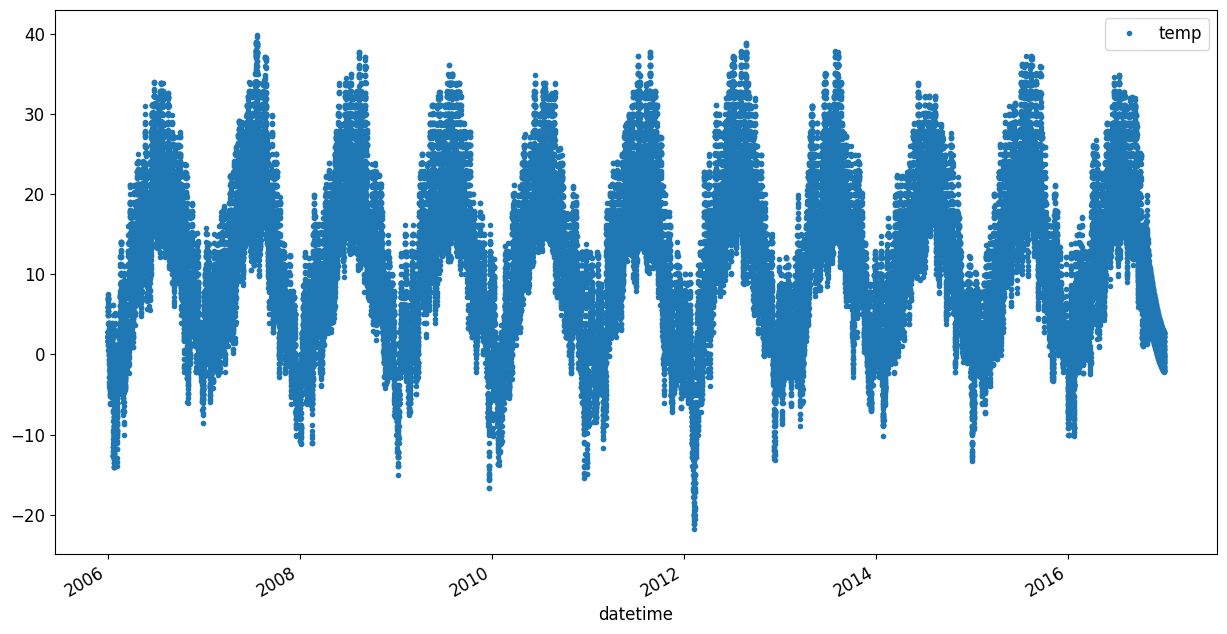

In [13]:
ax= temp_df.plot(x= 'datetime', y= 'temp',style ='.');

In [14]:
h_units= 100 # hidden_units = no of nodes/neurons in the hidden layer
input_shape =(1,10000) # 10000 vocab

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape= input_shape))
model.add(tf.keras.layers.SimpleRNN(units= h_units, activation = 'tanh'))
          # units = Positive integer, dimensionality of the output space.
          # tanh is default activation
model.add(tf.keras.layers.Dense(1, activation = 'linear'))

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100)            │     1,010,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,201 (3.85 MB)

 Trainable params: 1,010,201 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# for ax in model.get_weights():
#     print(ax.shape)

# from documentation we know the position of Wax.....
print(f'Wzx = {model.get_weights()[0].shape}')
print(f'Waa = {model.get_weights()[1].shape}')
print(f'ba = {model.get_weights()[2].shape}')
print(f'Way = {model.get_weights()[3].shape}')
print(f'by = {model.get_weights()[4].shape}')

Wzx = (10000, 100)
Waa = (100, 100)
ba = (100,)
Way = (100, 1)
by = (1,)


In [17]:
time_step = 24
temp_df.shape[0]/time_step
# 4018*24 = 96432
y_idx= np.arange(time_step, temp_df.shape[0], time_step)
y_df=temp_df.iloc[y_idx]
y_df # it is our target

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556
...,...,...
96336,2016-12-27 02:00:00+00:00,-1.627778
96360,2016-12-28 02:00:00+00:00,-1.677778
96384,2016-12-29 02:00:00+00:00,-1.727778
96408,2016-12-30 02:00:00+00:00,-1.777778


In [18]:
X_df = temp_df.iloc[range(len(y_df)*time_step)]
X_df.shape

(96432, 2)

In [19]:
# reshape to match number of rows in y_df
X = np.reshape(X_df['temp'].values, (y_df.shape[0], time_step)) # reshaped one day in:  24 hrs as columns , and each hour in row
X.shape, y_df.shape

((4018, 24), (4018, 2))

In [20]:
X

array([[ 0.57777778,  1.16111111,  1.66666667, ...,  4.93333333,
         5.47222222,  5.42222222],
       [ 5.42222222,  2.35      ,  5.42222222, ...,  2.80555556,
         2.31111111,  1.69444444],
       [ 1.69444444,  1.73333333,  1.66666667, ...,  2.24444444,
         2.25555556,  2.2       ],
       ...,
       [-1.67777778, -1.93333333, -2.03333333, ..., -0.78333333,
        -1.06666667, -1.4       ],
       [-1.72777778, -1.98888889, -2.08333333, ..., -0.82777778,
        -1.11666667, -1.44444444],
       [-1.77777778, -2.03333333, -2.13333333, ..., -0.87222222,
        -1.16111111, -1.48888889]])

In [21]:
# remove last column 
X=X[:,:23] #removed the last column becuse the 24'th hours value is stored in 'y'(target) so to not repeat it we are removing it
X.shape

(4018, 23)

In [22]:
X[0],y_df.head(1)

(array([0.57777778, 1.16111111, 1.66666667, 1.71111111, 1.18333333,
        1.20555556, 2.22222222, 2.07222222, 2.2       , 2.73333333,
        2.78888889, 3.82222222, 4.91111111, 6.20555556, 7.43888889,
        6.95      , 5.97222222, 5.90555556, 4.95555556, 5.47222222,
        5.97222222, 4.93333333, 5.47222222]),
                     datetime      temp
 24 2006-01-01 23:00:00+00:00  5.422222)

In [23]:
# [samples(rows), timesteps, features(columns)]

X= np.reshape(X, (X.shape[0], X.shape[1],1))
X.shape

(4018, 23, 1)

In [24]:
X

array([[[ 0.57777778],
        [ 1.16111111],
        [ 1.66666667],
        ...,
        [ 5.97222222],
        [ 4.93333333],
        [ 5.47222222]],

       [[ 5.42222222],
        [ 2.35      ],
        [ 5.42222222],
        ...,
        [ 2.85555556],
        [ 2.80555556],
        [ 2.31111111]],

       [[ 1.69444444],
        [ 1.73333333],
        [ 1.66666667],
        ...,
        [ 2.24444444],
        [ 2.24444444],
        [ 2.25555556]],

       ...,

       [[-1.67777778],
        [-1.93333333],
        [-2.03333333],
        ...,
        [-0.54444444],
        [-0.78333333],
        [-1.06666667]],

       [[-1.72777778],
        [-1.98888889],
        [-2.08333333],
        ...,
        [-0.59444444],
        [-0.82777778],
        [-1.11666667]],

       [[-1.77777778],
        [-2.03333333],
        [-2.13333333],
        ...,
        [-0.63888889],
        [-0.87222222],
        [-1.16111111]]])

In [25]:
split = int(y_df.shape[0]* (1- TEST_SIZE))
split

3214

In [26]:
X_train = X[:split]
X_test = X[split:]
y_train= y_df['temp'].values[:split]
y_test= y_df['temp'].values[split:]
X_train.shape , y_train.shape

((3214, 23, 1), (3214,))

In [27]:
X[[[0]]]

array([[[[0.57777778],
         [1.16111111],
         [1.66666667],
         [1.71111111],
         [1.18333333],
         [1.20555556],
         [2.22222222],
         [2.07222222],
         [2.2       ],
         [2.73333333],
         [2.78888889],
         [3.82222222],
         [4.91111111],
         [6.20555556],
         [7.43888889],
         [6.95      ],
         [5.97222222],
         [5.90555556],
         [4.95555556],
         [5.47222222],
         [5.97222222],
         [4.93333333],
         [5.47222222]]]])

In [38]:
h_units= 256 # hidden_units = no of nodes/neurons in the hidden layer
input_shape =(time_step - 1, 1) # 23, 1
initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape= input_shape))
model.add(tf.keras.layers.SimpleRNN(units= h_units,
                                    kernel_initializer = initializer,
                                    activation = 'tanh'))
          # units = Positive integer, dimensionality of the output space.
          # tanh is default activation
model.add(tf.keras.layers.Dense(1,
                                kernel_initializer = initializer,
                                activation = 'linear'))

In [40]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 256)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
EPOCHS

30

In [44]:
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = [tf.keras.metrics.RootMeanSquaredError(name = 'RMS', dtype = None)])


history = model.fit( x = X_train, y = y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
          validation_data = [X_test, y_test],
          verbose = 1)

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - RMS: 1.4461 - loss: 2.1894 - val_RMS: 0.8945 - val_loss: 0.8002
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - RMS: 1.1085 - loss: 1.2308 - val_RMS: 0.8912 - val_loss: 0.7943
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - RMS: 1.1076 - loss: 1.2303 - val_RMS: 0.8733 - val_loss: 0.7627
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - RMS: 1.0961 - loss: 1.2040 - val_RMS: 0.8307 - val_loss: 0.6900
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - RMS: 1.0825 - loss: 1.1743 - val_RMS: 0.8496 - val_loss: 0.7218
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - RMS: 1.0844 - loss: 1.1782 - val_RMS: 0.8752 - val_loss: 0.7660
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - RMS: 1.0898 - loss: 1.1903 - val_RMS: 0.8530 - val_loss: 0.7277
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - RMS: 1.1207 - loss: 1.2578 - val_RMS: 0.8708 - val_loss: 0.7583
Epoch 9/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/

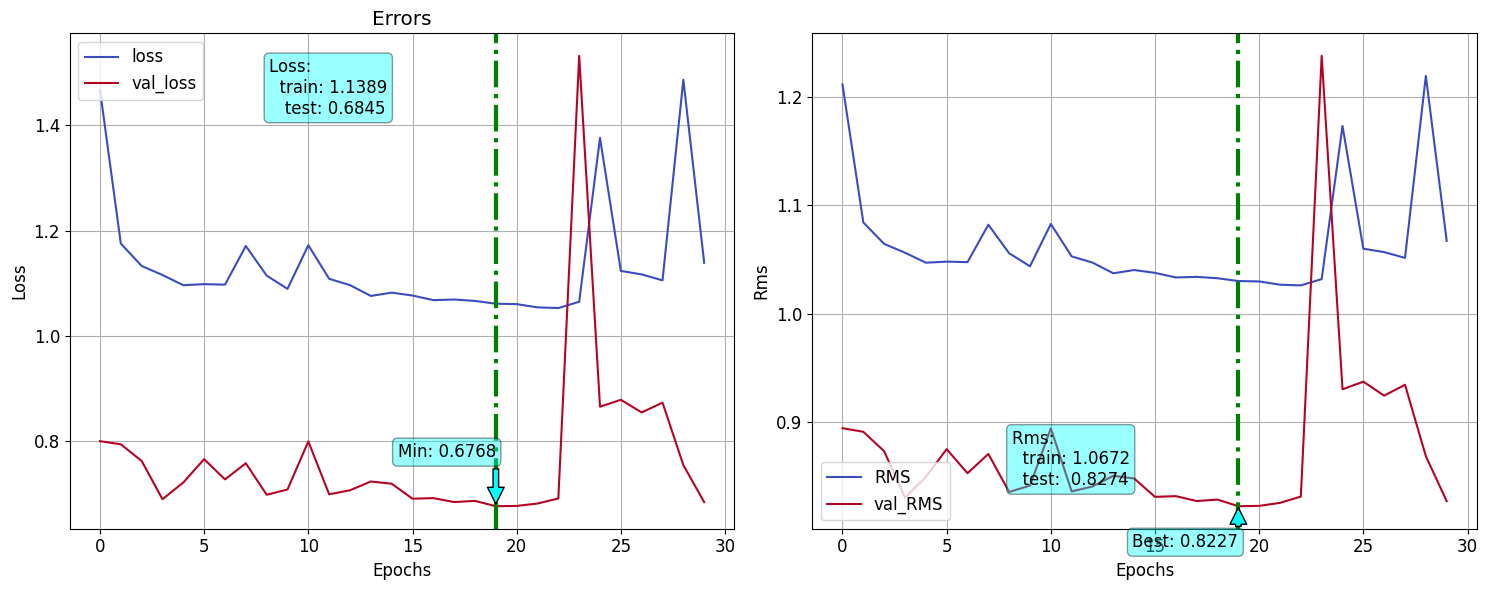

In [45]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [60]:
y_tr_pred = model.predict(X_train)
y_ts_pred = model.predict(X_test)
y_pred = np.append(y_tr_pred, y_ts_pred)

res_df = y_df.copy()
res_df['pred'] = y_pred
res_df.head()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,datetime,temp,pred
24,2006-01-01 23:00:00+00:00,5.422222,5.019945
48,2006-01-02 23:00:00+00:00,1.694444,1.898319
72,2006-01-03 23:00:00+00:00,2.200000,2.068681
96,2006-01-04 23:00:00+00:00,1.666667,1.980281
120,2006-01-05 23:00:00+00:00,1.805556,2.398429


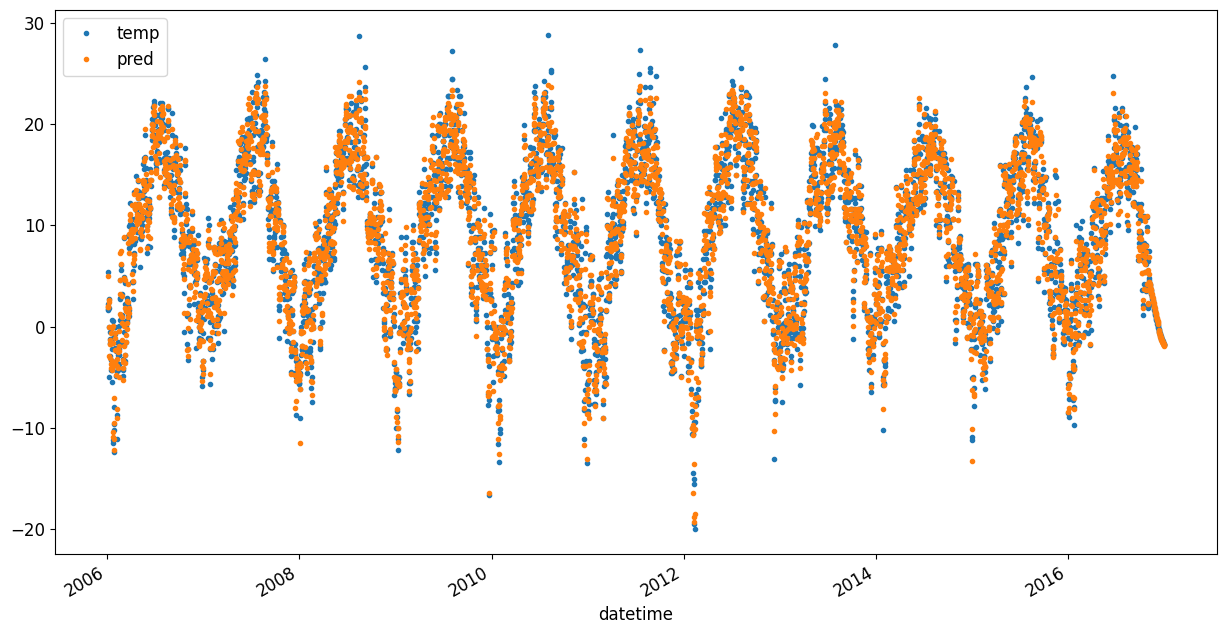

In [68]:
res_df.plot(x = 'datetime', y = ['temp', 'pred'], style = '.');

((804,), (804,))